In [12]:
# 魔术指令，自动加载模块
%load_ext autoreload
%autoreload 2
import os
os.chdir("/home/beihang/xihu/HZTourism/FlowPred-dev")
import sys
sys.path.append("/home/beihang/xihu/HZTourism/FlowPred-dev")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 评估

In [19]:
exper_name = "wheather_enhence_his24h-pred6h"
exper_dir = f"exper/{exper_name}"
exper_data_dir = f"exper_data/{exper_name}"
os.makedirs(exper_data_dir, exist_ok=True)

spot_id = 14100
his_hour = 24
pred_hour = 6
if spot_id in [14210,14211,14212,14213]:
    freq = "10min"
    his_len = 144
    pred_len = 36
elif spot_id in [14207,14209]:
    freq = "30sec"
    his_len = 2880
    pred_len = 720
elif spot_id in [14208]:
    freq = "1min"
    his_len = 1440
    pred_len = 360
else:
    freq = "5min"
    his_len = 288
    pred_len = 72
raw_dir = f"{exper_data_dir}/raw/{spot_id}"
proc_dir = f"{exper_data_dir}/proc/{spot_id}"
test_dir = f"{exper_data_dir}/test/{spot_id}"
res_dir = f"{exper_data_dir}/res/{spot_id}"

eva_dir = f"{exper_dir}/eva"
test_res_basedir = f"{exper_data_dir}/res/{spot_id}"

os.makedirs(f"{eva_dir}/{spot_id}", exist_ok=True)
os.makedirs(test_res_basedir, exist_ok=True)
os.makedirs(raw_dir, exist_ok=True)
os.makedirs(proc_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
os.makedirs(res_dir, exist_ok=True)
os.makedirs(eva_dir, exist_ok=True)

In [14]:
# 根据景点加载测试数据
# 加载测试数据
from src.utils.utils_eva_db import save_csv_from_db

s_time = "2025-01-01"
s_time_input = f"{s_time} 00:00:00"
e_time = "2025-06-30"
if e_time is None:
    raw_file_name = f"{spot_id}_{s_time}"
    test_raw_data_file=f"{raw_dir}/{raw_file_name}.csv"
    e_time_input = None
else:
    raw_file_name = f"{spot_id}_{s_time}_{e_time}"
    test_raw_data_file=f"{raw_dir}/{raw_file_name}.csv"
    e_time_input = f"{e_time} 23:59:59"
save_csv_from_db(
    spot_id=spot_id,
    s_time=s_time_input,
    e_time=e_time_input,
    output_csv_file=test_raw_data_file,
)

数据库连接成功！
正在从表 'mobile_signaling_tourists_num' 中查询数据，景点ID: 14100，时间范围: 2025-01-01 00:00:00 至 2025-06-30 23:59:59...
输出表头: ['spot_id', 'kpi_time', 'kpi_value']
CSV 文件表头已写入。
成功！筛选后的数据已导出到文件 'exper_data/wheather_enhence_his24h-pred6h/raw/14100/14100_2025-01-01_2025-06-30.csv'，共 49650 条记录。
数据库连接已关闭。


In [15]:
import pandas as pd
# 数据预处理
df = pd.read_csv(test_raw_data_file)
# 按kpi_time列转换为datetime格式
df['kpi_time'] = pd.to_datetime(df['kpi_time'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
# 按kpi_time去重
df = df.drop_duplicates(subset=['kpi_time'])
# 按kpi_time排序
df = df.sort_values(by='kpi_time')
# 数据预处理，分景点
if spot_id in [14210,14211,14212,14213]:
    freq = "10min"
    pass
elif spot_id in [14207,14209]:
    freq = "30sec"
    from src.utils.utils_data import fill_missing_value_singlespot_30s
    df_proc = fill_missing_value_singlespot_30s(spot_id, df)
elif spot_id in [14208]:
    freq = "1min"
else:
    freq = "5min"
    from src.utils.utils_data import fill_missing_value_singlespot_day,get_df_diff_less_k
    # df_proc_filter = get_df_diff_less_k(df, 288)
    df_proc = fill_missing_value_singlespot_day(df, freq=freq)

df_proc.to_csv(f"{proc_dir}/{raw_file_name}_proc.csv", index=False)

In [16]:
# 数据处理为模型输入形式

from src.pattern.pattern_train import get_group_annotation, save_mode_data
df_proc = pd.read_csv(f"{proc_dir}/{raw_file_name}_proc.csv")
save_base_dir = test_dir
os.makedirs(save_base_dir, exist_ok=True)
groups_mode_0, groups_mode_1 = get_group_annotation(his_len=his_len,pred_len=pred_len, df=df_proc, time_interval=freq)
save_mode_data(
    groups_mode=groups_mode_0,
    mode=0,
    data_basepath=save_base_dir,
)
save_mode_data(
    groups_mode=groups_mode_1,
    mode=1,
    data_basepath=save_base_dir,
)

Starting group annotation...
Getting continuous groups...


Building continuous groups:   0%|          | 0/52132 [00:00<?, ?row/s]

Building continuous groups: 100%|██████████| 52132/52132 [00:02<00:00, 18142.78row/s]


Found 3 continuous groups
Processing groups (his_len=288, pred_len=72)...


Processing continuous groups: 100%|██████████| 3/3 [00:31<00:00, 10.34s/group]


Generated 34 holiday batches and 69 workday batches
Final merging and deduplicating...


Merging batches: 100%|██████████| 1/1 [00:00<00:00, 12.45it/s]


Final holiday data: 26300 rows
Final workday data: 44788 rows
Getting final continuous groups...


Building continuous groups: 100%|██████████| 44788/44788 [00:02<00:00, 18347.38row/s]


Final holiday groups: 26
Final workday groups: 28
Saving 26 groups to mode_0...


Saving mode_0 files: 100%|██████████| 26/26 [00:00<00:00, 321.55file/s]


Mode_0 data saved successfully!
Saving 28 groups to mode_1...


Saving mode_1 files: 100%|██████████| 28/28 [00:00<00:00, 231.40file/s]

Mode_1 data saved successfully!


In [17]:
# 进行测试
# 执行对应的脚本
from src.utils.config import get_args
from src.exp.exp_main import Exp_Main
args = get_args()
args.is_training=0
args.use_weather = True
args.data_multi_basedir = f"{exper_data_dir}/test"
args.mask_spectrum_dir= f"{exper_dir}/maskspectrum"
args.test_res_save_dir= f"{exper_data_dir}/res"
args.spot_id = spot_id
args.seq_len = his_len
args.label_len = pred_len
args.pred_len = pred_len
args.checkpoints = f"{exper_dir}/checkpoint"
args.gpu= "0"

# args.use_gpu = False

print(args)
# mode0
mode = 0
args.mode = mode
exp = Exp_Main(args)
exp.test_save_res()

# mode1
mode = 1
args.mode = mode
exp = Exp_Main(args)
exp.test_save_res()

Namespace(is_training=0, model_id='Flow_Koopa', model='Koopa', data='Flow', datadir_flag=True, root_path='data/pred_6h_args/ogn/24/288_72/mode_0', data_multi_basedir='exper_data/wheather_enhence_his24h-pred6h/test', data_path='14100_preprocessed.csv', mask_spectrum_dir='exper/wheather_enhence_his24h-pred6h/maskspectrum', test_res_save_dir='exper_data/wheather_enhence_his24h-pred6h/res', features='S', target='kpi_value', freq='5min', checkpoints='exper/wheather_enhence_his24h-pred6h/checkpoint', spot_id=14100, mode='0', his_hour=24, pred_hour=6, seq_len=288, label_len=72, pred_len=72, enc_in=1, dec_in=1, c_out=1, dropout=0.05, embed='timeF', do_predict=False, num_workers=10, itr=1, train_epochs=10, batch_size=32, patience=5, learning_rate=0.001, des='test', loss='PearsonMSELoss', lradj='type1', use_amp=False, use_gpu=True, gpu='0', use_multi_gpu=False, devices='0', seed=2023, dynamic_dim=128, hidden_dim=64, hidden_layers=2, seg_len=48, num_blocks=3, alpha=0.2, multistep=False, use_weath

In [ ]:
from src.evaluation.metrics import evaluate_comparison
# 计算指标
df_eva = evaluate_comparison(
    f"{test_res_basedir}/mode0/result.csv", 
    f"{test_res_basedir}/mode1/result.csv", 
    pred_len=pred_len
)

df_eva.to_csv(f"{eva_dir}/{spot_id}/{spot_id}_{exper_name}_eva.csv", index=False)

df_eva

,指标,节假日,工作日,评价标准
0,数值偏差 (MAPE),0.18,0.16,"越小越好, <0.15为良好"
1,峰值时间偏差 (分钟),1455.0,20.0,"越小越好, <20分钟为良好"
2,稳定性 (变异系数),0.14,0.15,"越小越好, <0.1为良好"
3,波动率 (VR),0.981,0.934,"越接近1越好, 0.95~1.05为良好"
4,趋势准确率 (相关系数),0.821,0.763,"越接近1越好, >0.85为良好"


In [21]:
print(spot_id)

14100


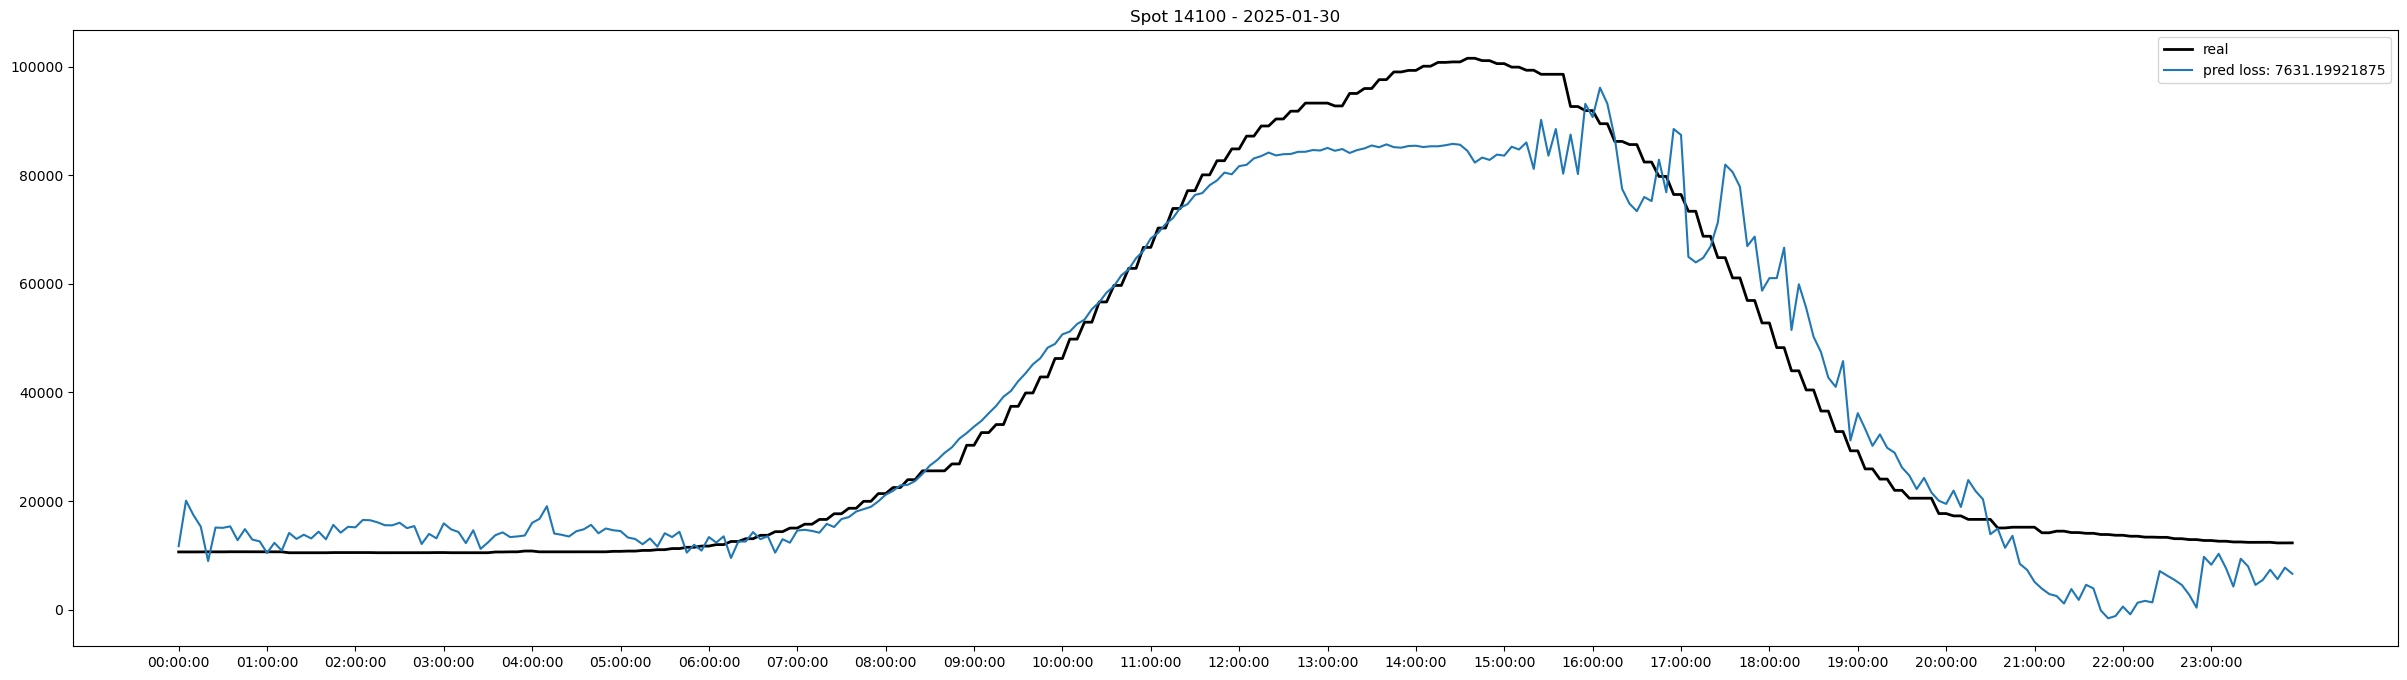

In [22]:
%matplotlib inline
from src.utils.utils_eva_db import view_res_multi
res_paths = [f"{test_res_basedir}/mode0/result.csv",f"{test_res_basedir}/mode1/result.csv"]
view_res_multi(*res_paths, prediction_selection="last",pred_len=pred_len, save_plots=False,eva_test_dir=eva_dir, spot_id=spot_id)